# Homework 02 - Regression
The goal of this homework is to create a regression model for predicting the car fuel efficiency.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Dataset
This homework will use the Car Fuel Efficiency dataset.
Use only the following columns:
 - `engine_displacement`
 - `horsepower`
 - `vehicle_weight`
 - `model_year`
 - `fuel_efficiency_mpg`

In [2]:
cfe_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
cfe_df = pd.read_csv(cfe_url)
cfe_df.columns = cfe_df.columns.str.lower().str.replace(' ', '_')
cfe_df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

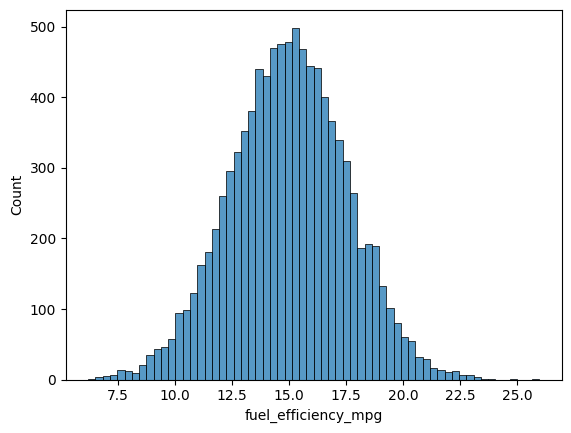

In [3]:
sns.histplot(cfe_df.fuel_efficiency_mpg)

## Question 1:
Which column has missing values?

In [4]:
cfe_df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']].isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

## Question 2
What's the median `horsepower`?

In [5]:
print(cfe_df.horsepower.median())

149.0


## Prepare the dataset
- Shuffle the data (use seed `42`)
- Split the data into train, val, and test sets (60/20/20 split)

In [6]:
def prepare_dataset(df, idx_seed):
    n = len(df)
    n_val = int(n * 0.2)
    # val and test buckets are the same size
    n_train = n - n_val - n_val

    idx = np.arange(n)
    np.random.seed(idx_seed)
    np.random.shuffle(idx)

    train_df = df.iloc[idx[:n_train]].reset_index(drop=True)
    val_df = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop=True)
    test_df = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)

    return train_df, val_df, test_df


In [7]:
train_df, val_df, test_df = prepare_dataset(cfe_df, 42)

(len(cfe_df), len(train_df), len(val_df), len(test_df), len(cfe_df) == (len(train_df) + len(val_df) + len(test_df)))

(9704, 5824, 1940, 1940, True)

## Train the model

In [8]:
def train_linear_regression(X, y, r):
    ones = np.ones(X.shape[0])
    _X = np.column_stack([ones, X])

    XTX = _X.T @ _X
    XTX_r = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX_r)
    w_full = (XTX_inv @ _X.T) @ y

    return w_full[0], w_full[1:]

In [9]:
def rmse(y, y_pred):
    err = y_pred - y
    sqrd_err = err ** 2
    mean_sqrd_err = sqrd_err.mean()
    return np.sqrt(mean_sqrd_err)

In [10]:
def prepare_X(df, fillna):
    result = pd.DataFrame()
    
    features = [
        'engine_displacement',
        'horsepower',
        'vehicle_weight',
        'model_year'
    ]

    for col in features:
        if col in fillna:
            result[col] = df[col].fillna(fillna[col])
        else:
            result[col] = df[col].fillna(0)
    
    return result.values

In [11]:
def train_and_test(df, fillna={}, r=0, idx_seed=42, graph=False, test=False):
    t_df, v_df, test_df = prepare_dataset(df, idx_seed)

    if test:
        train_df = pd.concat([t_df, v_df])
        train_df.reset_index(drop=True)
        val_df = test_df
    else:
        train_df = t_df
        val_df = v_df
    
    train_X = prepare_X(train_df, fillna)
    train_y = train_df.fuel_efficiency_mpg.values
    
    val_X = prepare_X(val_df, fillna)
    val_y = val_df.fuel_efficiency_mpg.values

    w0, w = train_linear_regression(train_X, train_y, r)

    pred_y = w0 + (val_X @ w)
    if graph == True:
        sns.histplot(pred_y, label="prediction", color="red", alpha=0.5, bins=50)
        sns.histplot(val_y, label="target", color="blue", alpha=0.5, bins=50)
        plt.legend()
    
    return rmse(val_y, pred_y)

## Question 3
We need to deal with the missing values for the `horsepower` column.
We can either:
- Replace missing values with `0`, or
- replace missing values with the `mean` of `horsepower`

Which option gives a better RMSE?

In [12]:
score_fillna_0 = train_and_test(cfe_df)

means = { "horsepower": train_df["horsepower"].mean() }
score_fillna_mean = train_and_test(cfe_df, fillna=means)

print(f"nan=0, rmse={round(score_fillna_0, 4)}; nan=mean, rmse={round(score_fillna_mean, 4)}")

nan=0, rmse=0.5174; nan=mean, rmse=0.4636


## Question 4
Using fillna=0 and regularization, which value of `r` gives the best RMSE?

In [13]:
regularizations = [0, 0.01, 0.1, 1, 5, 10, 100]
result = "Findings: "
for r in regularizations:
    score = train_and_test(cfe_df, r=r)
    result += f"\n  {r}\t{round(score, 4)}"

print(result)

Findings: 
  0	0.5174
  0.01	0.5171
  0.1	0.5188
  1	0.5222
  5	0.5229
  10	0.523
  100	0.5231


## Question 5
How does the seed value of `42` influence our scores?  Using fillna=0 and regularization=0, calculate the standard deviation of the RMSE scores.

In [14]:
rmse_scores = []
for seed in range(10):
    rmse_scores.append(train_and_test(cfe_df, idx_seed=seed))
print(round(np.std(rmse_scores), 4))

0.007


## Question 6
Continue testing by combining the train and validation dadtasets.  What is the RMSE on the test dataset?  Use seed=9, fillna=0, and regularization-0.001.

0.5156


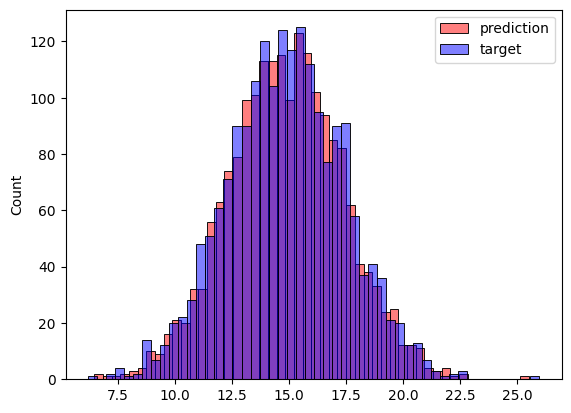

In [15]:
rmse_score = train_and_test(cfe_df, r=0.001, idx_seed=9, test=True, graph=True)
print(round(rmse_score, 4))